#Gaussian Naive Bayes Algorithm

In this notebook we present our implementation of the Gaussian Naive Bayes algorithm. The algorithm was trained and tested in the iris and wine dataset. It's aim is to showcase in depth knowledge of the algorithm , and not to solve any complex problem. At the next cell we import all the the nessecary libraries that we are going to use. The implemented Naive Bayes algorithm from sklearn was used in order to compare our model's accuracy.


In [ ]:
import numpy as np
from numpy.linalg import det, inv
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score ,f1_score,recall_score

##Softmax function implementation

First and foremost we create the softmax function , in order to turn the outputs of our algorithm into probabilities. :

The softmax function is given by the formula:

$$
\sigma(x_i) = \frac{e^{x_i}}{\sum_{j=1}^{K} e^{x_j}}
$$

where:
- $ \sigma(z)_i $ is the $(i)$-th component of the softmax output vector.
- $e$ is the base of the natural logarithm (Euler's number).
- $x_i$ is the $(i)$-th element of the input vector $( x )$.
- $K$ is the total number of classes.



In [ ]:
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e_x / np.sum(e_x, axis=-1, keepdims=True)

##Normal Distribution

In order to calculate the probability for every class we are going to use the normal distribution. The probability density function (PDF) of a multivariate normal distribution is given by the formula:

$$
f(\mathbf{x}|\boldsymbol{\mu}, \Sigma) = \frac{1}{(2\pi)^{n/2}|\Sigma|^{1/2}} \exp\left(-\frac{1}{2}(\mathbf{x} - \boldsymbol{\mu})^T \Sigma^{-1} (\mathbf{x} - \boldsymbol{\mu})\right)
$$

Where:
- $f(\mathbf{x}|\boldsymbol{\mu}, \Sigma)$ is the probability density function.
-$\mathbf{x}$ is the vector of random variables.
- $\boldsymbol{\mu}$ is the mean vector.
- $\Sigma$ is the covariance matrix.
- $n$ is the dimensionality of the multivariate distribution.


In [ ]:
def GaussianDistribution(X, mean, cov):
    k = len(mean)
    diff = X - mean
    cov_inverse = inv(cov)
    exponent = -0.5 * np.dot(np.dot(cov_inverse, diff.T), diff)
    coefficient = 1 / np.sqrt((2 * np.pi) ** k * det(cov))
    prob = coefficient*np.exp(exponent)

    return prob


##Gaussian Naive Bayes implementation

We've created a class for our classifier. The constructor of the class has 3 dictionaries. The means, covariance matrices , and the prior probabilities of each class. In the Naive Bayes algorithm we assume that the features are independent , so the covariance matrices for every class would be diagonal.

The Bayes' Theorem is given by the following formula:
<br>
<br>
$$
P(A|B) = \frac{P(B|A) \cdot P(A)}{P(B)}
$$

Where:

- $P(A|B)$ is the posterior probability of event A given B.
- $P(B|A)$ is the likelihood of event B given A.
- $P(A)$ is the prior probability of event A.
- $P(B)$ is the probability of event B.
<br>
<br>

Since $P(B)$ remains constant for all classes , we don't include it in our computations. So, given an observation $x$=$(x_1, x_2, x_3, \ldots, x_n$), the probability of this observation belonging to a ceratin class would be:
<br>
<br>
$$
P(class=c|x)=P(x_1|class=c)P(x_2|class=c)P(x_3|class=c)\ldots P(x_n|class=c)\cdot P(class=c)=$$
$$P(class=c)\cdot \prod_{i=1}^{n}P(x_d|class=c)
$$
<br>
Where:
- $x$ is the given observation.
- $P(class)$ is the prior probability of the class.
- $P(x|class)$ is probability of observing $x$ given the fact that it belongs to this certain class.
-$P(class|x)$ is the probability we want to evaluate.

**Below we notate the term we are interested in as LL (we've assumed that every feature $x_d$ follows a normal distribution with mean=$μ_{dc}$ and variance=$s_{dc}$ and is independent of every other feature -naive assumption-), and we are proving mathematically what we intuitively expect for the MLΕ to be: ***
<br>
<br>
*( While the calculations in the following section are demonstrated for a single-variable normal distribution, it is crucial to note that all procedures and principles illustrated here can straightforwardly be extended to a multivariate , like the one we use in our code above. )*
<br>
<br>
$$max[\sum_{i:y_{ic}=1}\log(p(x_d | \theta_{dc}))]=$$
<br>
$$\sum_{i:y_{ic}=1}\log\left(\frac{1}{{s_{dc}}^{1/2}}\cdot\frac{1}{2π^{1/2}}\cdot exp(-\frac{1}{2}\cdot \frac{(x_{id}-μ_{dc})^{2}}{s_{dc}})\right)=$$
<br>
$$\sum_{i:y_{ic}=1}(-\frac{1}{2}logs_{dc}-\frac{1}{2}log2π-\frac{1}{2}\cdot \frac{(x_{id}-μ_{dc})^{2}}{s_{dc}})$$
<br>
Now , if we take the derivate of LL with respect to the mean=$μ_{dc}$ and set it equal to zero , we come to the conclusion that:

$$μ_{dc}=\frac{1}{N_c}\cdot \sum_{i:y_{ic}=1}x_{id}=\hat{μ_{dc}}$$
<br>
And if we calculate the derivative of LL with respect to $s_{dc}$ and set it equal to zero , we come to the conclusion that:

$$s_{dc}=\frac{1}{N_c}\cdot \sum_{i:y_{ic}=1}(x_{id}-\hat{μ_{dc}})^2$$


Where $\hat{μ_{dc}}$ is the MLE for $μ_{dc}$. So , we are going to calculate the mean and the variance of the sample data we have in order to get the maximum likelihood estimate.
<br>
<br>
In our fit method we caclulate the mean and the variance for every class, and also it's priors, and store them in our dictionaries.
<br>
<br>
In our predict method , we pass the parameters of every class to our normal distribution fuction , and calculate the probability of the given example belonging to every single class. At last , we take the argmax, and mark it as our prediction.


In [ ]:
class GaussianNaiveBayes:
  def __init__(self):
    self.class_means={}
    self.class_cov={}
    self.class_priors={}

  def fit(self,X,y):
    num_classes=len(np.unique(y))
    num_features=X.shape[1]
    self.class_means = {label: np.zeros(num_features) for label in range(num_classes)}
    self.class_covariances = {label: np.zeros((num_features, num_features)) for label in range(num_classes)}
    total_docs = len(y)

    for label in range(num_classes):
      class_data = X[y.flatten() == label]
      self.class_means[label] = np.mean(class_data, axis=0)
      self.class_covariances[label] = np.diag(np.var(class_data, axis=0) + 1e-6)
      self.class_priors[label]=np.sum(y==label)/total_docs


  def predict(self, X):
      predictions = []
      num_classes = len(self.class_priors)

      for x_example in X:
          probs = []
          for label in range(num_classes):
              prob = GaussianDistribution(x_example, mean=self.class_means[label], cov=self.class_covariances[label])
              prob*=self.class_priors[label]
              probs.append(prob)

          normalized_probs=softmax(probs)
          prediction = np.argmax(normalized_probs)
          predictions.append(prediction)

      return predictions


#Loading and ploting the Iris dataset

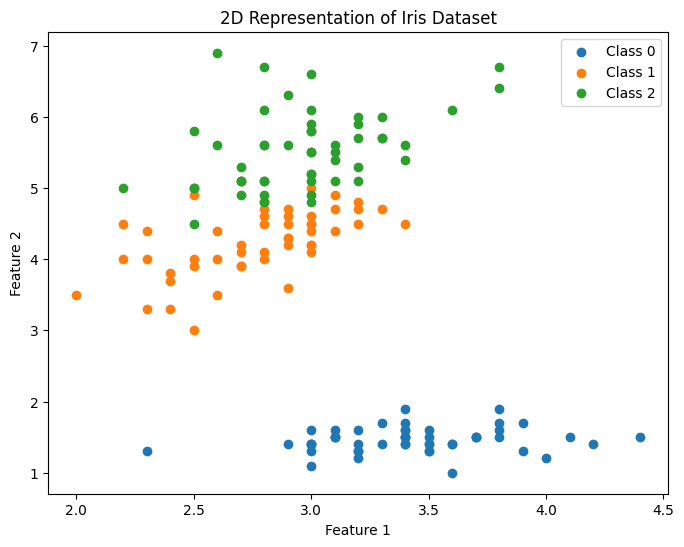

In [ ]:
iris = load_iris()
X, y = iris.data, iris.target


plt.figure(figsize=(8, 6))

for label in range(3):
    X_label = X[y == label]
    plt.scatter(X_label[:, 1], X_label[:, 2], label=f"Class {label}")

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("2D Representation of Iris Dataset")
plt.legend()
plt.show()

X_train_iris, X_val_iris, Y_train_iris, Y_val_iris = train_test_split(
    X, y, test_size=0.2, random_state=42
)



#Training of the IRIS dataset , and comparing it with sklearn's implementation



In [ ]:
gnb_iris = GaussianNaiveBayes()
gnb_iris.fit(X_train_iris, Y_train_iris)


Y_test_pred = gnb_iris.predict(X_val_iris)
y_train_pred=gnb_iris.predict(X_train_iris)

print('Our models report: ')

print(classification_report(Y_test_pred,Y_val_iris))


sklearn_NB=GaussianNB()

sklearn_NB.fit(X_train_iris, Y_train_iris)
Y_test_pred = sklearn_NB.predict(X_val_iris)
y_train_pred=sklearn_NB.predict(X_train_iris)

print('Sklearn models report: ')
print(classification_report(Y_test_pred,Y_val_iris))



Our models report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

Sklearn models report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



#Loading and ploting the wine dataset

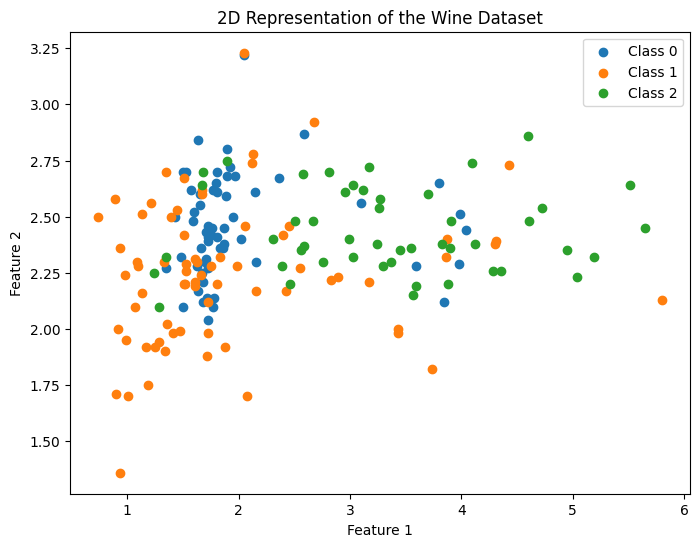

In [ ]:
from sklearn.datasets import load_wine


wine = load_wine()
X, y = wine.data, wine.target

plt.figure(figsize=(8, 6))

for label in range(3):
    X_label = X[y == label]
    plt.scatter(X_label[:, 1], X_label[:, 2], label=f"Class {label}")

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("2D Representation of the Wine Dataset")
plt.legend()
plt.show()

#Training with the Wine dataset, and comparing it with sklearn's implmentation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


gnb = GaussianNaiveBayes()
gnb.fit(X_train, y_train)
y_test_pred = gnb.predict(X_test)

print('Our model report: ')
print(classification_report(y_test_pred,y_test))


gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_test_pred = gnb.predict(X_test)

print('Sklearn model report: ')
print(classification_report(y_test_pred,y_test))



Our model report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00         8

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36

Sklearn model report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00         8

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36

